In [1]:
#automatically reload stuff
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import re
import Formatting
from scipy import stats
import Metrics
from Constants import Const
import copy
import Utils
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.stats import power_divergence, chisquare, chi2_contingency

from dtaidistance import dtw_ndim, clustering
from Models import PatientKNN
import Cluster
pd.set_option('display.max_columns', None)

In [2]:
from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
#Andrews code for formatting the symptom data

In [4]:
def get_dates(columns):
    alldates = set([])
    for col in columns:
        if 'mdasi' in col:
            week = symptom_weektime(str(col))
            alldates.add(week)
    return sorted(alldates)

def valid_cols(df, columns):
    valid = list(set(df.columns).intersection(set(columns)))
    invalid = set(columns) - set(df.columns)
    return valid,invalid
    

def get_mdasi_rename_dict():
    #placehold for renaming columns later, based on "MDASI.csv" headings
    col_dict = {'site_of_tumor': 'subsite',
                'RT_duration': 'duration',
                'AGE': 'age',
                't_nominal': 't_stage',
                'n_nominal': 'n_stage',
                'Overall_survival': 'os',
                'Death_days': 'death_days',
                'Fudays': 'followup_days',
                'bc':'bootcamp_therapy',
                'Performance_score': 'performance_score',
                'm':'m_stage'
               }
    return col_dict

def symptom_weektime(string):
    #parses the column for each symptom into the number of weeks after baseline
    s = string.lower().strip().replace('_','')
    if 'baseline' in s:
        return 0
    elif 'startrt' in s:
        return 1
    elif 'endrt' in s:
        return 7
    week_regex = re.match("wk(\d+)",s)
    postweek_regex = re.match('wk(\d+)post',s)
    month_regex = re.match('m(\d+)',s)
    if postweek_regex is not None:
        return 7 + int(postweek_regex.group(1))
    elif week_regex is not None:
        return int(week_regex.group(1))
    elif month_regex is not None:
        return 7 + int(4.35*float(month_regex.group(1)))
    return -1

def get_symptom(string):
    s = string.lower().strip()
    regex = re.match('.*mdasi_([a-z]+)',s)
    if regex is not None:
        return regex.group(1)
    #because someone decided changing the name scheme for activity was a good idea
    else:
        if 'activity' in s:
            return 'activity'
    return False

def format_symptoms(df,
                 to_keep=None,
                symptoms=None,
                     ):
    if to_keep is None:
        to_keep = ['id',
            'is_male','age',
            'subsite','duration',
            't_stage','n_stage',
            'is_ajcc_8th_edition',
            'hpv','rt','ic',
            'nd','rt_type',
            'concurrent','performance_score',
            'os','followup_days','chemotherapy',
            'typetreatment','treatment2',
                           ]
    valid,invalid = valid_cols(df,to_keep)
    if len(invalid) > 0:
        print('missing columns',invalid)
    new_df = df[valid].copy()
    if symptoms is None:
        symptoms = Const.symptoms
    dates = get_dates(df.columns)
    new_df['dates'] = [dates for i in range(new_df.shape[0])]
    for s in symptoms:
        scols = [i for i in df.columns if get_symptom(i) == s]
        scols = sorted(scols,key = lambda x: symptom_weektime(x))
        values = df.loc[:,scols].values.tolist()
        new_df['symptoms_'+s] = values
    return new_df

def format_mdasi_columns(df):
    cd = get_mdasi_rename_dict()
    df = df.rename(columns = cd, inplace=False)
    df.loc[:,'is_male'] = df.sex.apply(lambda x: x > 1)
    df.loc[:,'is_ajcc_8th_edition'] = df.ajcc_version.apply(lambda x : (x > 1 if not np.isnan(x) else -1))
    df.loc[:,'hpv'] = df.p16_hpv_postive.apply(lambda x: (x if x in [0,1] else -1))
    df.loc[~df['os'].isnull(),'os'] = df.loc[~df['os'].isnull(),'os'].apply(lambda x: int('alive' in str(x.lower())))
    
    #some weird formatting here
    df.loc[df.t_stage == 'tx','t_stage'].t_stage = 't1'
    df.loc[df.t_stage == 'nx','n_stage'].t_stage = 'n1'
    df.loc[df.t_stage == 'NOS','t_stage'] = np.nan
    df.loc[df.n_stage == 'NOS','n_stage'] = np.nan
    return format_symptoms(df)

def filter_bad_mdasi_rows(df):
    required = ['baseline_mdasi_pain','endRT_mdasi_pain','Overall_survival']
    print('before drop count',df.shape[0])
    df = df.dropna(subset=required)
    print('after drop count',df.shape[0])
    return df
    
def load_mdasi(file = None):
    if file is None:
        file = Const.mdasi_folder + 'MDASI_09092021.xlsx'
    if 'xlsx' in file:
        dframe = pd.read_excel(file)
    else:
        dframe = pd.read_csv(file)
    dframe =filter_bad_mdasi_rows(dframe)
    dframe = format_mdasi_columns(dframe)
    return dframe

# df = load_mdasi()
df = load_mdasi()
df

before drop count 823
after drop count 371


,duration,hpv,concurrent,age,treatment2,is_ajcc_8th_edition,rt,followup_days,rt_type,typetreatment,nd,chemotherapy,ic,id,performance_score,is_male,n_stage,subsite,t_stage,os,dates,symptoms_pain,symptoms_fatigue,symptoms_nausea,symptoms_sleep,symptoms_distress,symptoms_sob,symptoms_memory,symptoms_appetite,symptoms_drowsy,symptoms_drymouth,symptoms_sad,symptoms_vomit,symptoms_numb,symptoms_mucus,symptoms_swallow,symptoms_choke,symptoms_voice,symptoms_skin,symptoms_constipation,symptoms_taste,symptoms_mucositis,symptoms_teeth,symptoms_activity,symptoms_mood,symptoms_work,symptoms_relations,symptoms_walking,symptoms_enjoy
0,44.00000,1.0,1.0,72.0,Cr,False,1.0,203.0,3.0,Cr,0.0,concurrent_chemotherapy,0.0,1,0,True,n2b,BOT,t1,0,"[0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]","[1.0, nan, nan, nan, nan, nan, 5.0, 7.0, 3.0, ...","[1.0, nan, nan, nan, nan, 1.0, 3.0, 6.0, 7.0, ...","[0.0, nan, nan, nan, nan, 0.0, 2.0, 0.0, 0.0, ...","[1.0, nan, nan, nan, nan, 0.0, 4.0, 7.0, 8.0, ...","[1.0, nan, nan, nan, nan, 0.0, 1.0, 1.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 2.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 3.0, 7.0, 4.0, ...","[0.0, nan, nan, nan, nan, 0.0, 1.0, 5.0, 2.0, ...","[0.0, nan, nan, nan, nan, 1.0, 1.0, nan, 0.0, ...","[1.0, nan, nan, nan, nan, 0.0, 1.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 2.0, 2.0, 4.0, 1.0, ...","[0.0, nan, nan, nan, nan, 2.0, 3.0, 7.0, 2.0, ...","[0.0, nan, nan, nan, nan, 0.0, 1.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 2.0, 5.0, 0.0, ...","[0.0, nan, nan, nan, nan, 2.0, 4.0, 8.0, 5.0, ...","[0.0, nan, nan, nan, nan, 1.0, 3.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 1.0, 3.0, 4.0, 8.0, ...","[0.0, nan, nan, nan, nan, 0.0, 3.0, 8.0, 2.0, ...","[0.0, nan, nan, nan, nan, 0.0, 2.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 1.0, 2.0, 8.0, 4.0, ...","[1.0, nan, nan, nan, nan, 1.0, nan, 1.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 10.0, 4.0,...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 3.0, 7.0, 4.0, ...","[0.0, nan, nan, nan, nan, 0.0, 3.0, 1.0, 0.0, ..."
5,44.00000,1.0,1.0,67.0,Cr,-1,1.0,990.0,2.0,Cr,0.0,concurrent_chemotherapy,0.0,6,1,True,n2b,BOT,t2,0,"[0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]","[10.0, nan, nan, nan, nan, nan, nan, 10.0, nan...","[8.0, nan, nan, nan, nan, nan, nan, 9.0, nan, ...","[6.0, nan, nan, nan, nan, nan, nan, 9.0, nan, ...","[5.0, nan, nan, nan, nan, nan, nan, 7.0, nan, ...","[5.0, nan, nan, nan, nan, nan, nan, 9.0, nan, ...","[2.0, nan, nan, nan, nan, nan, nan, 2.0, nan, ...","[3.0, nan, nan, nan, nan, nan, nan, 5.0, nan, ...","[3.0, nan, nan, nan, nan, nan, nan, 8.0, nan, ...","[7.0, nan, nan, nan, nan, nan, nan, 9.0, nan, ...","[9.0, nan, nan, nan, nan, nan, nan, 10.0, nan,...","[3.0, nan, nan, nan, nan, nan, nan, 10.0, nan,...","[0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, ...","[7.0, nan, nan, nan, nan, nan, nan, 2.0, nan, ...","[0.0, nan, nan, nan, nan, nan, nan, 7.0, nan, ...","[5.0, nan, nan, nan, nan, nan, nan, 9.0, nan, ...","[2.0, nan, nan, nan, nan, nan, nan, 7.0, nan, ...","[6.0, nan, nan, nan, nan, nan, nan, 8.0, nan, ...","[0.0, nan, nan, nan, nan, nan, nan, 8.0, nan, ...","[2.0, nan, nan, nan, nan, nan, nan, 0.0, nan, ...","[9.0, nan, nan, nan, nan, nan, nan, 9.0, nan, ...","[7.0, nan, nan, nan, nan, nan, nan, 10.0, nan,...","[6.0, nan, nan, nan, nan, nan, nan, 10.0, nan,...","[7.0, nan, nan, nan, nan, nan, nan, 8.0, nan, ...","[7.0, nan, nan, nan, nan, nan, nan, 9.0, nan, ...","[4.0, nan, nan, nan, nan, nan, nan, 9.0, nan, ...","[2.0, nan, nan, nan, nan, nan, nan, 9.0, nan, ...","[6.0, nan, nan, nan, nan, nan, nan, 5.0, nan, ...","[7.0, nan, nan, nan, nan, nan, nan, 9.0, nan, ..."
8,44.00000,1.0,1.0,50.0,SCr,False,1.0,1884.0,2.0,CrS,1.0,concurrent_chemotherapy,0.0,9,0,True,n2a,Tonsil,t1,1,"[0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]","[

In [5]:
import Autoencoders as AE
from Formatting import nan_mse_loss, numpy_nan_reconstruction_error
from Pytorchtools import EarlyStopping
import torch

def flat_mdasi_df(df, columns = [], symptoms = None):
    if columns is None:
        columns = [c for c in df.columns if 'symptoms' not in c]
    if symptoms is None:
        symptoms = [c for c in df.columns if 'symptoms' in c]
    arrays = []
    for col in columns:
        print(col, df[col].dtype)
        vals = df[col].copy()
        vals[vals.isnull()] = np.nan
        is_num = True
        try: 
            vals.astype('float')
        except:
            is_num = False
        if (not is_num) or len(vals.unique()) < 5:
            vals = pd.get_dummies(vals,drop_first=True)
            vals.columns = [col + "|" + str(c) for c in vals.columns]
        arrays.append(vals)
    val_df = pd.concat(arrays,axis=1)
    for sym in symptoms:
        symp_df = []
        svals = df[sym]
        svals = np.stack(svals.values)
        for i in range(svals.shape[1]):
            timestep = svals[:,i]
            name = sym+'_t'+str(int(i))
            val_df[name] = timestep
    val_df.index = df.id
    return val_df


def get_symptom_denoiser_path(**kwargs):
    return Const.pytorch_model_dir + 'symptom_autoencoder'
        
def train_symptom_autoencoder(x_numpy, 
                              loss_idx=None,
                              model_path=None,
                              lr = .001,
                              patience = 200,
                              epochs = 20000,
                              **kwargs
                             ):
    autoencoder = AE.BasicDenoiser(x_numpy.shape[1],**kwargs)
    if model_path is None:
        model_path = get_symptom_denoiser_path(model=autoencoder,
                                               lr = lr,epochs = epochs)
    x_torch = torch.tensor(x_numpy).float()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    early_stopping = EarlyStopping(patience = patience, path=model_path)
    losses=[]
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = autoencoder(x_numpy)
        if loss_idx is not None:
            loss = nan_mse_loss(y_pred[:,loss_idx],x_torch[:,loss_idx])
        else:
            loss = nan_mse_loss(y_pred,x_torch)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        torch.cuda.empty_cache()
        early_stopping(loss.item(), autoencoder)
        print(epoch,'loss:',loss,end='\r')
        if early_stopping.early_stop:
            print('training stopped on epoch', epoch - patience)
            break
    autoencoder.load_state_dict(torch.load(model_path))
    print()
    return autoencoder.eval(), early_stopping.get_loss_history()
    
def impute_symptom_values(df,
                   additional_vars= None, 
                   limit_loss = False, 
                   use_trained=True,
                   model_path = None,
                  ):
    if additional_vars is None:
        additional_vars = ['ic','rt','concurrent','n_stage','t_stage']
    if model_path is None:
        model_path = get_symptom_denoiser_path()
    flat_df = flat_mdasi_df(df,additional_vars)
    x = flat_df.values
    scol_pos = [i for i,c in enumerate(flat_df.columns) if 'symptom' in c]
    loss_idx = None
    if limit_loss:
        loss_idx = scol_pos
    if use_trained:
        #will fail if I cahnged the model parameters
        try:
            ae= AE.BasicDenoiser(x.shape[1])
            ae.load_state_dict(torch.load(model_path))
            ae = ae.eval()
        except Exception as e:
            print('training failed')
            print(e)
            use_trained = False
    if not use_trained:
        ae, loss_hist = train_symptom_autoencoder(x, loss_idx = loss_idx)
    xpred = ae(x).detach().numpy()
    xpred = np.rint(xpred)
    error = numpy_nan_reconstruction_error(xpred[:,scol_pos],x[:,scol_pos])
    print('error (%)',error)
    new_df = flat_df.copy()
    new_df[new_df.isnull()] = xpred.astype(float)
    return new_df

def get_flat_symptom(x):
    match = re.match('symptoms_(.+)_t(\d+)',x)
    if match is not None:
        return match.group(1), int(match.group(2))
    return None,None
    
def group_imputed_symptoms(row,symptom):
    cols = [i for i in row.index if symptom.lower() in str(i).lower()]
    cols = sorted(cols,key = lambda x: get_flat_symptom(x)[1])
    vals = row[cols]
    return list(vals.values)

def unflatten_symptom_df(flat_df,original_df=None):
    unflat_df = []
    symptoms = [get_flat_symptom(c)[0] for c in flat_df.columns if 'symptom' in c]
    symptoms = sorted(set(symptoms))
    #index should be id for flattend index
    for pid, row in flat_df.iterrows():
        entry = {'symptoms_'+s: group_imputed_symptoms(row,s) for s in symptoms}
        entry['id'] = pid
        unflat_df.append(entry)
        print(pid,'/',flat_df.shape[0],end='\r')
    unflat_df = pd.DataFrame(unflat_df)
    if original_df is not None:
        return pd.merge(original_df,unflat_df,on='id',how='right',suffixes=['_original',''])
    return pd.DataFrame(unflat_df)

            
def impute_symptom_df(df):
    #imputes nan symptom values using a basic neural net
    imputed_flattened_df = impute_symptom_values(df, use_trained=True)
    imputed_df = unflatten_symptom_df(imputed_flattened_df,df)
    return imputed_df

def get_grouped_symptoms(df,use_original=False):
    def average_cols(row):
        vals = np.nanmean(np.stack(row.values),axis=0)
        vals = np.nan_to_num(vals)
        print(vals.shape)
        return vals
    
    df = df.copy()
    groups = Const.symptom_category_map
    for gname, symptoms in groups.items():
        scols = ['symptoms_' + s for s in symptoms]
        if use_original:
            scols = [s + '_original' for s in scols]
        df['symptomgroup_'+gname] = df[scols].apply(average_cols,axis=1)
    return df

def impute_and_group(df):
    idf = impute_symptom_df(df)
    return get_grouped_symptoms(idf)

#imput
# temp_df = impute_symptom_df(df)
# imputed_df = get_grouped_symptoms(temp_df)
imputed_df = impute_and_group(df)
imputed_df

ic float64
rt float64
concurrent float64
n_stage object
t_stage object
error (%) 0.6613060137437216
(13,) 371
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(13,)
(1

,duration,hpv,concurrent,age,treatment2,is_ajcc_8th_edition,rt,followup_days,rt_type,typetreatment,nd,chemotherapy,ic,id,performance_score,is_male,n_stage,subsite,t_stage,os,dates,symptoms_pain_original,symptoms_fatigue_original,symptoms_nausea_original,symptoms_sleep_original,symptoms_distress_original,symptoms_sob_original,symptoms_memory_original,symptoms_appetite_original,symptoms_drowsy_original,symptoms_drymouth_original,symptoms_sad_original,symptoms_vomit_original,symptoms_numb_original,symptoms_mucus_original,symptoms_swallow_original,symptoms_choke_original,symptoms_voice_original,symptoms_skin_original,symptoms_constipation_original,symptoms_taste_original,symptoms_mucositis_original,symptoms_teeth_original,symptoms_activity_original,symptoms_mood_original,symptoms_work_original,symptoms_relations_original,symptoms_walking_original,symptoms_enjoy_original,symptoms_activity,symptoms_appetite,symptoms_choke,symptoms_constipation,symptoms_distress,symptoms_drowsy,symptoms_drymouth,symptoms_enjoy,symptoms_fatigue,symptoms_memory,symptoms_mood,symptoms_mucositis,symptoms_mucus,symptoms_nausea,symptoms_numb,symptoms_pain,symptoms_relations,symptoms_sad,symptoms_skin,symptoms_sleep,symptoms_sob,symptoms_swallow,symptoms_taste,symptoms_teeth,symptoms_voice,symptoms_vomit,symptoms_walking,symptoms_work,symptomgroup_core,symptomgroup_interference,symptomgroup_hnc
0,44.00000,1.0,1.0,72.0,Cr,False,1.0,203.0,3.0,Cr,0.0,concurrent_chemotherapy,0.0,1,0,True,n2b,BOT,t1,0,"[0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]","[1.0, nan, nan, nan, nan, nan, 5.0, 7.0, 3.0, ...","[1.0, nan, nan, nan, nan, 1.0, 3.0, 6.0, 7.0, ...","[0.0, nan, nan, nan, nan, 0.0, 2.0, 0.0, 0.0, ...","[1.0, nan, nan, nan, nan, 0.0, 4.0, 7.0, 8.0, ...","[1.0, nan, nan, nan, nan, 0.0, 1.0, 1.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 2.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 3.0, 7.0, 4.0, ...","[0.0, nan, nan, nan, nan, 0.0, 1.0, 5.0, 2.0, ...","[0.0, nan, nan, nan, nan, 1.0, 1.0, nan, 0.0, ...","[1.0, nan, nan, nan, nan, 0.0, 1.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 2.0, 2.0, 4.0, 1.0, ...","[0.0, nan, nan, nan, nan, 2.0, 3.0, 7.0, 2.0, ...","[0.0, nan, nan, nan, nan, 0.0, 1.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 2.0, 5.0, 0.0, ...","[0.0, nan, nan, nan, nan, 2.0, 4.0, 8.0, 5.0, ...","[0.0, nan, nan, nan, nan, 1.0, 3.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 1.0, 3.0, 4.0, 8.0, ...","[0.0, nan, nan, nan, nan, 0.0, 3.0, 8.0, 2.0, ...","[0.0, nan, nan, nan, nan, 0.0, 2.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 1.0, 2.0, 8.0, 4.0, ...","[1.0, nan, nan, nan, nan, 1.0, nan, 1.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 10.0, 4.0,...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 3.0, 7.0, 4.0, ...","[0.0, nan, nan, nan, nan, 0.0, 3.0, 1.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 8.0, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 3.0, 7.0, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 0.0, 0.0, ...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 5.0, 2.0, ...","[0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 3.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 3.0, 6.0, 7.0, ...","[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 8.0, 2.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 4.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 2.0, 3.0, 5.0, 7.0, 3.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 4.0, 8.0, 5.0, ...","[1.0, 1.0, 0.0, 

In [6]:
imputed_df.to_csv(Const.data_dir + 'patient_symptom_formatted.csv')

In [7]:
imputed_df.dates.iloc[0]

[0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]

In [8]:
def df_to_symptom_array(df,use_groups = True, simplify = True):
    df = df.copy()
    #determines if we use 3 the
    keyword = 'symptoms_'
    if use_groups:
        keyword = 'symptomgroup_'
    symptom_cols = [c for c in df.columns if (keyword in c) and ('original' not in c)]
    print(symptom_cols)
    def stack_row(row):
        vals = np.stack(row.values)
        return vals
    vals = np.stack(df[symptom_cols].apply(stack_row,axis=1).values)
    return vals

sarray = df_to_symptom_array(imputed_df,use_groups=True)

['symptomgroup_core', 'symptomgroup_interference', 'symptomgroup_hnc']


In [20]:
sim_measures = {
    'dtw': Metrics.DTWd2d(update=True),
    'dtw_delta': Metrics.DTWd2d(update=True,use_derivative=True),
    'dtw_m6': Metrics.DTWd2d(update=True,max_step=6),
    'dtw_delta_m6': Metrics.DTWd2d(update=True,use_derivative=True,max_step=6),
    'dtw_w2': Metrics.DTWd2d(update=True,window=2),
    'dtw_delta_w2': Metrics.DTWd2d(update=True,use_derivative=True,window=2),
    'em': Metrics.Wasserstein2d(),
    'em_delta': Metrics.Wasserstein2d(use_derivative=True),
    'jaccard': Metrics.Jaccard2d(),
    'jaccard_delta': Metrics.Jaccard2d(use_derivative=True),
    'euclidean': Metrics.Euclidean2D(),
    'euclidean_delta': Metrics.Euclidean2D(use_derivative=True),
    'cosine': Metrics.Cosine2d(),
    'cosine_delta': Metrics.Cosine2d(use_derivative=True),
    'chi2': Metrics.ChiSquared2d(),
    'chi2_delta': Metrics.ChiSquared2d(use_derivative=True),
}

def simplify_symptoms(array):
    def simple(val):
        if val <= 2:
            return 0
        if val <= 5:
            return 1
        if val <= 7:
            return 2
        return 3
    return np.vectorize(simple)(np.copy(array))


def contingency(v1,v2):
    n_v1 = len(np.unique(v1))
    n_v2 = len(np.unique(v2))
    table = np.zeros((n_v1,n_v2))
    for i, vv1 in enumerate(np.unique(v1)):
        for ii,vv2 in enumerate(np.unique(v2)):
            in_cell = (v1 == vv1) & (v2 == vv2)
            table[i,ii] = in_cell.sum()
    return table

def vector_chi2(x,y):
    x = x.ravel()
    y = y.ravel()
    ctable = contingency(x,y)
    return chi2_contingency(ctable)[1]
    
def make_symptom_clusters(array, sim_measure = 'dtw', n = 3, link='ward',n_timesteps=8,simplify=True):
    end = min(n_timesteps, array.shape[-1])
    x = array[:,:,0:end]
    if simplify:
        x = simplify_symptoms(x)
    print()
    clusterer = Cluster.SimilarityClusterer(n,link=link)
    sim_func = sim_measures.get(sim_measure)
    sim = sim_func.get_similarity_matrix(x)
    clusters = clusterer.fit_predict(sim)
    sscore = clusterer.silhouette()
    
    #hardcoded so i should fix later to correlate with long term effects
    #should really onl make sense if n_timesteps is  < 9
    outcome = (array[:,:,9:].max(axis=1).max(axis=1) > 5).astype(int)
    severe_late_chi2 = 1-vector_chi2(clusters,outcome)
    
    return {"clusters": clusters, 'similarity': sim, 'silhouette': sscore,'severe_late_chi2': severe_late_chi2}
    
links = ['ward']#['ward','single','average','centroid']
sequence_lengths = [8,9,10]#[8,9,10]#[8,9,10,11,12]
cluster_counts = [3,4,5,6]#[3,4,5]
measures = ['em','em_delta',
            'dtw','dtw_delta',
            'dtw_m6','dtw_delta_m6',
            'dtw_w2','dtw_delta_w2',
            'euclidean','euclidean_delta',
            'jaccard','jaccard_delta']

results = []
for n in cluster_counts:
    for link in links:
        clusterer = Cluster.SimilarityClusterer(n,link=link)
        for n_timesteps in sequence_lengths:
            for sname in measures:
                for simplify in [True,False]:
                    try:
                        entry = make_symptom_clusters(sarray, 
                                                      sim_measure=sname, 
                                                      n=n,
                                                      link=link,
                                                      n_timesteps=n_timesteps,
                                                      simplify=simplify,
                                                     )
                        entry['measure'] = sname
                        entry['clusterer'] = clusterer.brief()
                        entry['n_timesteps'] = n_timesteps
                        entry['simplify'] = simplify
                        entry['n_clusters'] = n
                        print(entry['measure'],entry['simplify'],entry['silhouette'],entry['severe_late_chi2'])
                        results.append(entry)
                    except Exception as e:
                        print(e)

res = pd.DataFrame(results)
res.sort_values('silhouette',ascending=False)


em True 0.17488964863887807 0.9869355130369193

em False 0.07290622195329778 0.9927764228752687

em_delta True 0.12822439269646105 0.9689813952281247

em_delta False 0.052209726447070164 0.9668756589383388

dtw True 0.03711485435420327 0.9768118850143342

dtw False 0.014668177041279118 0.9936515619927415

dtw_delta True 0.03711485435420327 0.9768118850143342

dtw_delta False 0.014668177041279118 0.9936515619927415

dtw_m6 True 0.034397805791725605 0.7580955091049786

dtw_m6 False 0.037182680377190164 0.9954171164076803

dtw_delta_m6 True 0.034397805791725605 0.7580955091049786

dtw_delta_m6 False 0.037182680377190164 0.9954171164076803

dtw_w2 True 0.03711485435420327 0.9768118850143342

dtw_w2 False 0.014668177041279118 0.9936515619927415

dtw_delta_w2 True 0.03711485435420327 0.9768118850143342

dtw_delta_w2 False 0.014668177041279118 0.9936515619927415

euclidean True 0.12003110527696205 0.8542284447182246

euclidean False 0.038570900980611666 0.8913746376075681

euclidean_delta Tr

dtw True 0.03670499418521989 0.8988880228714624

dtw False 0.007662373159682465 0.9911110660115898

dtw_delta True 0.03670499418521989 0.8988880228714624

dtw_delta False 0.007662373159682465 0.9911110660115898

dtw_m6 True 0.03244717498742478 0.7518652467752553

dtw_m6 False 0.01045496622700723 0.9903348173539775

dtw_delta_m6 True 0.03244717498742478 0.7518652467752553

dtw_delta_m6 False 0.01045496622700723 0.9903348173539775

dtw_w2 True 0.03670499418521989 0.8988880228714624

dtw_w2 False 0.007662373159682465 0.9911110660115898

dtw_delta_w2 True 0.03670499418521989 0.8988880228714624

dtw_delta_w2 False 0.007662373159682465 0.9911110660115898

euclidean True 0.1376781575261531 0.8148356898569643

euclidean False 0.012767916681445004 0.7753201126082704

euclidean_delta True 0.11971915331143577 0.6319311863161015

euclidean_delta False -0.0018602956792484217 0.9381849384782927

jaccard True -0.01249454200781528 0.9310011549050471

jaccard False -0.01611297434289786 0.73170560129696

,clusterer,clusters,measure,n_clusters,n_timesteps,severe_late_chi2,silhouette,similarity,simplify
0,simclust_ward_3_maxclust,"[1, 3, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, ...",em,3,8,0.986936,0.174890,"[[1.0, 0.1473684210526317, 0.7157894736842108,...",True
48,simclust_ward_3_maxclust,"[1, 3, 1, 2, 1, 1, 1, 2, 3, 2, 1, 2, 1, 2, 1, ...",em,3,10,0.979699,0.154079,"[[1.0, 0.09661835748792282, 0.7608695652173914...",True
232,simclust_ward_6_maxclust,"[6, 3, 1, 4, 1, 5, 3, 4, 2, 3, 1, 3, 1, 3, 6, ...",euclidean,6,8,0.712723,0.150393,"[[1.0, 0.04452660633567018, 0.2380952380952380...",True
50,simclust_ward_3_maxclust,"[2, 1, 3, 2, 3, 2, 1, 2, 2, 1, 3, 1, 3, 1, 2, ...",em_delta,3,10,0.848787,0.145456,"[[1.0, 0.3594771241830066, 0.5555555555555556,...",True
122,simclust_ward_4_maxclust,"[3, 2, 4, 3, 4, 3, 2, 3, 3, 1, 4, 2, 4, 1, 3, ...",em_delta,4,10,0.948962,0.142199,"[[1.0, 0.3594771241830066, 0.5555555555555556,...",True
24,simclust_ward_3_maxclust,"[1, 3, 1, 2, 1, 1, 1, 2, 3, 2, 1, 3, 1, 2, 1, ...",em,3,9,0.912185,0.141149,"[[1.0, 0.1304347826086957, 0.7402597402597402,...",True
160,simclust_ward_5_maxclust,"[5, 2, 1, 3, 1, 4, 2, 3, 2, 2, 1, 2, 1, 2, 5, ...",euclidean,5,8,0.814836,0.137678,"[[1.0, 0.04452660633567018, 0.2380952380952380...",True
26,simclust_ward_3_maxclust,"[2, 1, 3, 2, 3, 2, 1, 2, 2, 1, 3, 1, 3, 1, 2, ...",em_delta,3,9,0.848936,0.137537,"[[1.0, 0.3750000000000001, 0.519230769230769, ...",True
234,simclust_ward_6_maxclust,"[6, 3, 1, 4, 1, 2, 3, 5, 3, 3, 1, 3, 1, 3, 6, ...",euclidean_delta,6,8,0.734122,0.133028,"[[1.0, 0.10606743998822409, 0.2673234971348883...",True
98,simclust_ward_4_maxclust,"[3, 1, 4, 3, 4, 3, 2, 3, 3, 1, 4, 2, 4, 1, 3, ...",em_delta,4,9,0.934873,0.132057,"[[1.0, 0.3750000000000001, 0.519230769230769, ...",True


In [72]:
res.sort_values('severe_late_chi2',ascending=False)

,clusterer,clusters,measure,n_clusters,n_timesteps,severe_late_chi2,silhouette,similarity,simplify
131,simclust_ward_4_maxclust,"[2, 4, 1, 2, 1, 3, 2, 2, 4, 2, 2, 2, 1, 4, 2, ...",dtw_delta_m6,4,10,0.999998,0.022696,"[[1.0, 0.0, 0.18604955048185481, 0.11610682411...",False
129,simclust_ward_4_maxclust,"[2, 4, 1, 2, 1, 3, 2, 2, 4, 2, 2, 2, 1, 4, 2, ...",dtw_m6,4,10,0.999998,0.022696,"[[1.0, 0.0, 0.18604955048185481, 0.11610682411...",False
201,simclust_ward_5_maxclust,"[3, 5, 1, 3, 1, 4, 3, 3, 5, 3, 3, 3, 1, 5, 3, ...",dtw_m6,5,10,0.999994,0.000019,"[[1.0, 0.0, 0.18604955048185481, 0.11610682411...",False
203,simclust_ward_5_maxclust,"[3, 5, 1, 3, 1, 4, 3, 3, 5, 3, 3, 3, 1, 5, 3, ...",dtw_delta_m6,5,10,0.999994,0.000019,"[[1.0, 0.0, 0.18604955048185481, 0.11610682411...",False
273,simclust_ward_6_maxclust,"[4, 6, 1, 3, 1, 5, 3, 4, 6, 3, 3, 3, 1, 6, 4, ...",dtw_m6,6,10,0.999988,-0.000314,"[[1.0, 0.0, 0.18604955048185481, 0.11610682411...",False
275,simclust_ward_6_maxclust,"[4, 6, 1, 3, 1, 5, 3, 4, 6, 3, 3, 3, 1, 6, 4, ...",dtw_delta_m6,6,10,0.999988,-0.000314,"[[1.0, 0.0, 0.18604955048185481, 0.11610682411...",False
105,simclust_ward_4_maxclust,"[3, 1, 3, 2, 3, 2, 3, 3, 1, 1, 1, 2, 3, 1, 3, ...",dtw_m6,4,9,0.999905,0.013352,"[[1.0, 0.0, 0.19180447456115787, 0.11641972047...",False
107,simclust_ward_4_maxclust,"[3, 1, 3, 2, 3, 2, 3, 3, 1, 1, 1, 2, 3, 1, 3, ...",dtw_delta_m6,4,9,0.999905,0.013352,"[[1.0, 0.0, 0.19180447456115787, 0.11641972047...",False
264,simclust_ward_6_maxclust,"[2, 6, 1, 4, 1, 2, 2, 4, 5, 4, 1, 4, 1, 4, 2, ...",em,6,10,0.999873,0.091797,"[[1.0, 0.09661835748792282, 0.7608695652173914...",True
197,simclust_ward_5_maxclust,"[2, 5, 3, 2, 3, 4, 2, 2, 5, 2, 2, 2, 3, 5, 2, ...",dtw,5,10,0.999864,0.000441,"[[1.0, 0.026907848925955793, 0.157923064577950...",False


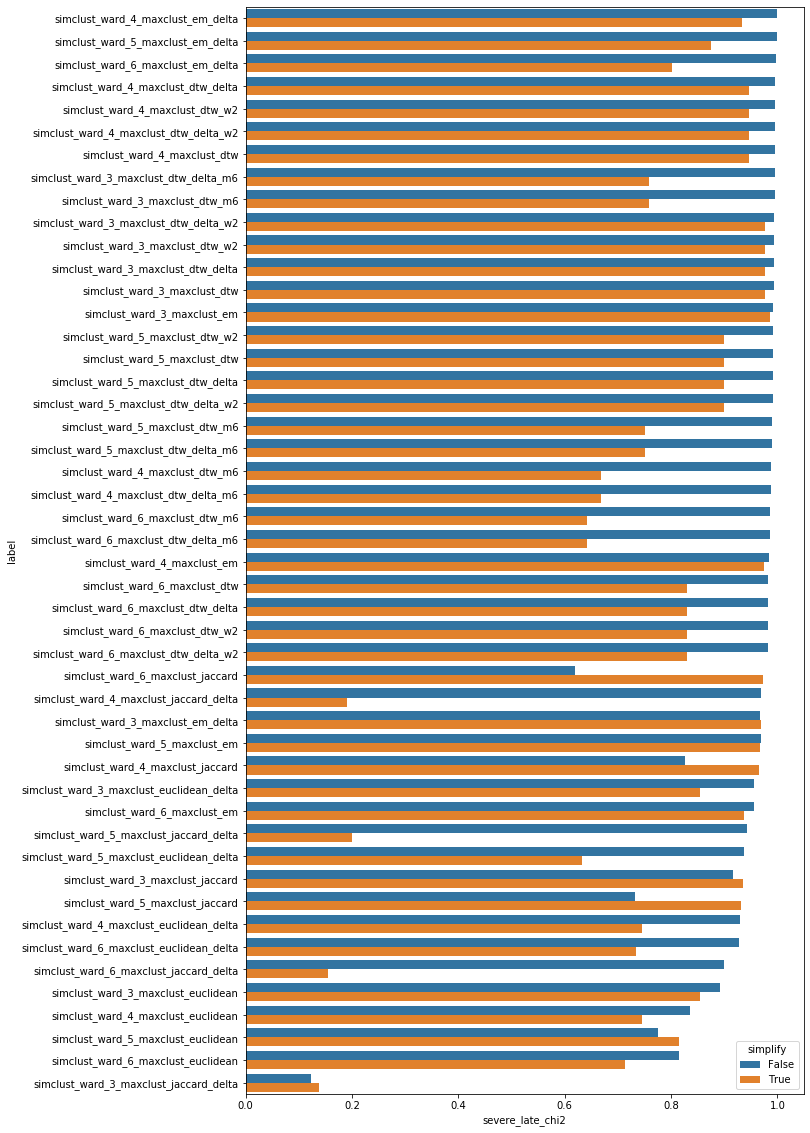

In [86]:
import seaborn as sns

def symptom_cluster_barplot(res, n_timesteps=8, value='severe_late_chi2'):
    if n_timesteps is not None:
        temp = res[res.n_timesteps == n_timesteps].copy()
    temp['label'] = (temp.clusterer + '_' + temp.measure)
    temp = temp.sort_values(value,ascending=False)
    plt.figure(figsize=(10,20))
    ax = sns.barplot(
        data = temp,
        orient='h',
        y = 'label',
        x = value,
        hue = 'simplify',
    #     order=['severe_late_chi2'],
    )
symptom_cluster_barplot(res)

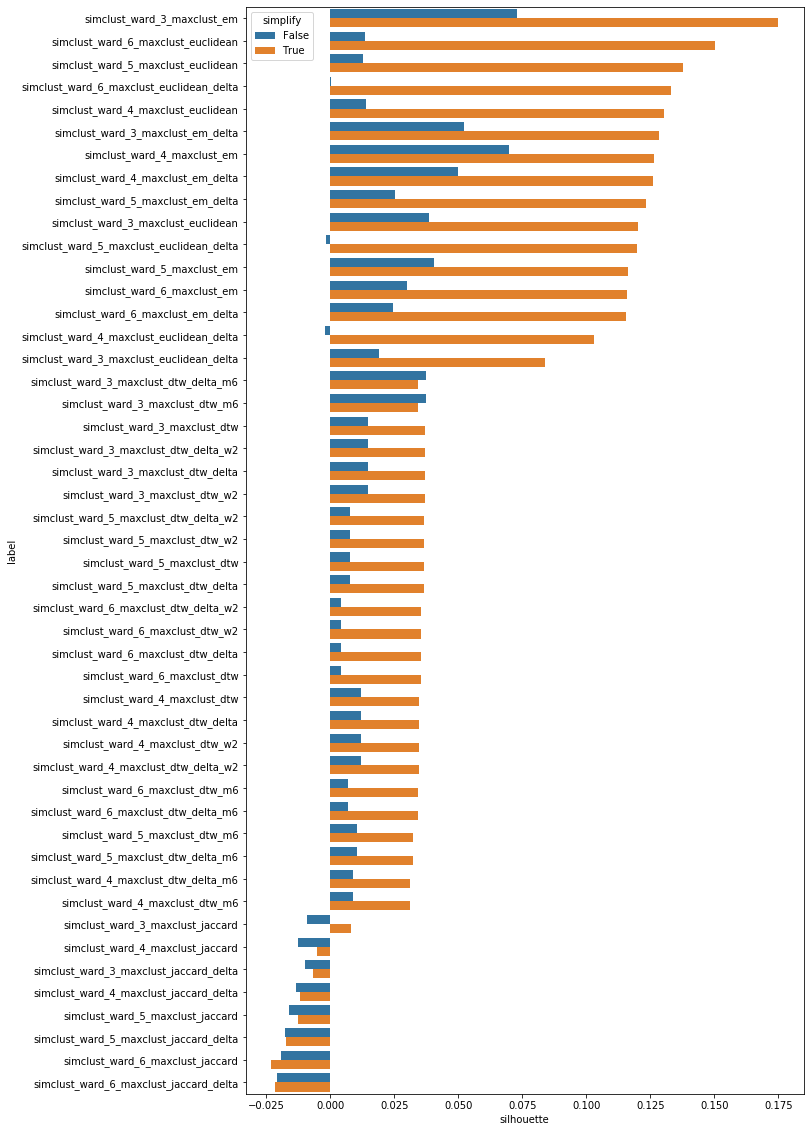

In [87]:
symptom_cluster_barplot(res,value='silhouette')

clusterer                                    simclust_ward_4_maxclust
clusters            [3, 1, 4, 3, 3, 3, 3, 3, 3, 1, 4, 3, 4, 2, 3, ...
measure                                                      em_delta
n_clusters                                                          4
n_timesteps                                                         8
severe_late_chi2                                             0.999382
silhouette                                                  0.0497956
similarity          [[1.0, 0.11570191353164677, 0.7439675421738201...
simplify                                                        False
Name: 75, dtype: object


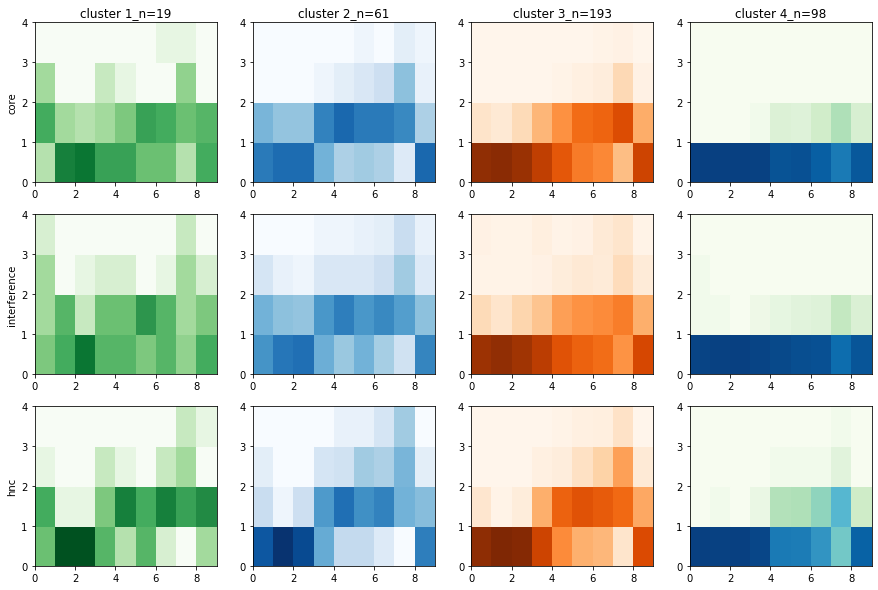

In [55]:
from matplotlib.patches import Rectangle

def plot_cluster_lines(x,clusters,timesteps = None,titles = None):
    colors = plt.get_cmap('tab20')
    labels = np.unique(clusters)
    n_channels = x.shape[1]
    if timesteps is None:
        timesteps = np.arange(x.shape[-1])
    n_timesteps = min(len(timesteps),x.shape[-1])
    timesteps=np.array(timesteps)[0:n_timesteps]
    fig,ax = plt.subplots(n_channels,len(labels),figsize=[15,10])
    if titles is None:
        titles = ['cluster ' + str(i) for i in clusters]
    for i,cluster in enumerate(labels):
        #list of lists, i think
        svals = x[clusters == cluster]
        alpha = 1/np.sqrt(svals.shape[0])
        for channel in range(n_channels):
            this_ax = ax[channel,i]
            plt.setp(this_ax, ylim=(0,x.max()))
            entrys = svals[:,channel,:n_timesteps]
            for entry in entrys:
                this_ax.plot(timesteps,entry,color=colors(i),alpha=alpha,linewidth=1.5)
            meanval = entrys.mean(axis=0).ravel()
            this_ax.plot(timesteps,meanval,color='black',alpha=.7,linewidth=2.5)
            if i == 0:
                this_ax.set_ylabel(titles[channel])
            if channel == 0:
                this_ax.set_title('cluster ' + str(cluster) + '_n=' + str(svals.shape[0]))

def plot_cluster_area(x,clusters,timesteps = None,titles = None):
    colors = plt.get_cmap('tab20')
    labels = np.unique(clusters)
    n_channels = x.shape[1]
    
    if timesteps is None:
        timesteps = np.arange(x.shape[-1])
    n_timesteps = min(len(timesteps),x.shape[-1])
    timesteps=np.array(timesteps)[0:n_timesteps]
    fig,ax = plt.subplots(n_channels,len(labels),figsize=[15,10])
    
    if titles is None:
        titles = ['cluster ' + str(i) for i in clusters]
        
    for i,cluster in enumerate(labels):
        svals = x[clusters == cluster]
        alpha = .75/svals.shape[0]
        for channel in range(n_channels):
            this_ax = ax[channel,i]
            plt.setp(this_ax, ylim=(0,x.max()))
            entrys = svals[:,channel,:n_timesteps]
            for entry in entrys:
                this_ax.plot(timesteps,entry,color=colors(i),alpha=alpha,linewidth=.1)
                this_ax.fill_between(timesteps,entry,color=colors(i),alpha=alpha)
            meanval = entrys.mean(axis=0).ravel()
            this_ax.plot(timesteps,meanval,color='black',alpha=.7,linewidth=2.5)
            if i == 0:
                this_ax.set_ylabel(titles[channel])
            if channel == 0:
                this_ax.set_title('cluster ' + str(cluster) + '_n=' + str(svals.shape[0]))
                
def simplify_symptoms(array):
    def simple(val):
        if val <= 2:
            return 0
        if val <= 5:
            return 1
        if val <= 7:
            return 2
        return 3
    return np.vectorize(simple)(np.copy(array))
                
def plot_cluster_bands(x,clusters,timesteps = None,titles = None):
    colors = plt.get_cmap('tab20')
    labels = np.unique(clusters)
    n_channels = x.shape[1]
    
    if timesteps is None:
        timesteps = np.arange(x.shape[-1])
    n_timesteps = min(len(timesteps),x.shape[-1])
    timesteps=np.array(timesteps)[0:n_timesteps]
    fig,ax = plt.subplots(n_channels,len(labels),figsize=[15,10])
    
    if titles is None:
        titles = ['cluster ' + str(i) for i in clusters]
        
    for i,cluster in enumerate(labels):
        svals = x[clusters == cluster]
        alpha = .5
        c = colors(i)
        for channel in range(n_channels):
            this_ax = ax[channel,i]
            plt.setp(this_ax, ylim=(0,x.max()))
            entrys = svals[:,channel,:n_timesteps]
            meanval = entrys.mean(axis=0).ravel()
            this_ax.plot(timesteps,meanval,color='black',alpha=.7,linewidth=2.5)
            ranges = [.01,.1,.25]
            for r in ranges:
                quantiles = np.quantile(entrys,[r,1-r],axis=0)
                for pos in [0,1]:
                    q = quantiles[pos]
                    this_ax.plot(timesteps,q,color=c,alpha=alpha,linewidth=1)
                this_ax.fill_between(timesteps,quantiles[0],quantiles[1],color=c,alpha=.25)
            if i == 0:
                this_ax.set_ylabel(titles[channel])
            if channel == 0:
                this_ax.set_title('cluster ' + str(cluster) + '_n=' + str(svals.shape[0]))
                
def plot_cluster_rectangles(x,clusters,timesteps = None,titles = None):
    cat_colors = [
        plt.get_cmap('Greens'),
        plt.get_cmap('Blues'),
        plt.get_cmap('Oranges'),
        plt.get_cmap('GnBu'),
        plt.get_cmap('Greys'),
        plt.get_cmap('Reds'),
        plt.get_cmap('RdPu'),
    ]
    labels = np.unique(clusters)
    x = simplify_symptoms(x)
    n_channels = x.shape[1]
    
#     if timesteps is None:
    timesteps = np.arange(x.shape[-1])
    n_timesteps = min(len(timesteps),x.shape[-1])
    timesteps=np.array(timesteps)[0:n_timesteps]
    fig,ax = plt.subplots(n_channels,len(labels),figsize=[15,10])
    
    if titles is None:
        titles = ['cluster ' + str(i) for i in clusters]
        
    for i,cluster in enumerate(labels):
        svals = x[clusters == cluster]
        alpha = .5
        cfunc = cat_colors[i]
        csize = svals.shape[0]
        for channel in range(n_channels):
            this_ax = ax[channel,i]
            plt.setp(this_ax,xlim=(0,timesteps.max()), ylim=(0,x.max()+1))
            
            entrys = svals[:,channel,:n_timesteps]
            for yval in range(int(x.max()+1)):
                for xval in timesteps:
                    count = (entrys[:,xval] == yval).sum()
                    ratio = count/csize
                    rect = Rectangle((xval,yval),1,1,color=cfunc(ratio**.75))
                    this_ax.add_patch(rect)
            if i == 0:
                this_ax.set_ylabel(titles[channel])
            if channel == 0:
                this_ax.set_title('cluster ' + str(cluster) + '_n=' + str(svals.shape[0]))
                
                
def plot_results(res_df, sarray,
                 plot_func = None,
                 dates=None, 
                 select_by='severe_late_chi2', 
                 sim = None,
                 n_clusters = None,
                 link=None,
                 simplify=None,
                 n_timesteps=None):
    df = res_df.copy()
    if sim is not None:
        df = df[df.measure == sim]
    if n_clusters is not None:
        df = df[df.n_clusters == n_clusters]
    if link is not None:
        df = df[df.clusterer.apply(lambda x: link in x)]
    if simplify is not None:
        df = df[df.simplify == simplify]
    if n_timesteps is not None:
        df = df[df.n_timesteps == n_timesteps]
#     best_result = df.sort_values('silhouette',ascending=False).iloc[0]\
    best_result = df.sort_values(select_by,ascending=False).iloc[0]
    print(best_result)
    clusters = best_result.clusters
    n_timesteps = 10#best_result.n_timesteps
    x = sarray[:,:,:n_timesteps]
    if plot_func is None:
        plot_func = plot_clusters
    plot_func(x,clusters,timesteps=dates,titles=['core','interference','hnc'])

temp_dates = None#imputed_df.dates.iloc[0]
plot_results(res,sarray,
#              plot_func=plot_cluster_lines,
             plot_func=plot_cluster_rectangles,
             dates=temp_dates,
#              sim='euclidean',
#              simplify=True,
             n_timesteps=8
            )

In [32]:
res.to_csv(Const.data_dir + 'cluster_test2_11-22.csv')

In [13]:
np.quantile(sarray[:,1,:],[.1,.5,.9],axis=0).shape

(3, 13)

In [14]:
sarray.max()

10.0